In [1]:
import os
import nibabel
import numpy as np
import ia_mri_tools
from ia_mri_tools.ia_mri_tools import coil_correction, textures
import pandas as pd

In [2]:
# Load the data
data_path = os.path.join(os.path.split(ia_mri_tools.__file__)[0], 'data/HCP/100307')
T1r = nibabel.load(os.path.join(data_path, 'T1w_acpc_dc_restore.nii.gz')).get_data()
T2r = nibabel.load(os.path.join(data_path, 'T2w_acpc_dc_restore.nii.gz')).get_data()
segs = nibabel.load(os.path.join(data_path, 'aparc+aseg.nii.gz')).get_data()

In [3]:
# Create textures
scales = [1, 2, 4, 8]
ns = len(scales)

tT1 = textures(T1r, scales)
tT2 = textures(T2r, scales)

In [4]:
# Reshape data to 1D
nvox = np.product(segs.shape)
rT1 = np.reshape(T1r, nvox)
rT2 = np.reshape(T2r, nvox)
rtT1 = np.reshape(tT1, [nvox, tT1.shape[3]])
rtT2 = np.reshape(tT2, [nvox, tT2.shape[3]])
rsegs = np.reshape(segs, nvox)

In [5]:
# Create dataframes for all of our data
df_T1 = pd.DataFrame(rT1, columns=['T1'])
df_T2 = pd.DataFrame(rT2, columns=['T2'])
seg = pd.DataFrame(rsegs, columns=['labels'])

df_tT1 = pd.DataFrame(rtT1)
df_tT2 = pd.DataFrame(rtT2)

In [6]:
# In order to label the 16 columns in both df_tT1 and df_tT2,
# we need to create a dictionary of labels
textures = ['smoothed', 'gradient', 'laplace', 'stddev']
scales = ['1', '2', '4', '8']
i = 0
labels_T1 = {}
for r in scales:
    for t in textures:
        labels_T1[i]='T1_'+r+'r_'+t
        i = i+1
i = 0
labels_T2 = {}
for r in scales:
    for t in textures:
        labels_T2[i]='T2_'+r+'r_'+t
        i = i+1

In [7]:
# Apply these labels to the dataframe columns
df_tT1 = df_tT1.rename(columns=labels_T1)
df_tT2 = df_tT2.rename(columns=labels_T2)

In [40]:
# Concatenate all DataFrames together into one complete data frame
data = pd.concat([df_T1, df_T2, df_tT1, df_tT2, seg], axis=1)

In [9]:
data.columns

Index([u'T1', u'T2', u'T1_1r_smoothed', u'T1_1r_gradient', u'T1_1r_laplace',
       u'T1_1r_stddev', u'T1_2r_smoothed', u'T1_2r_gradient', u'T1_2r_laplace',
       u'T1_2r_stddev', u'T1_4r_smoothed', u'T1_4r_gradient', u'T1_4r_laplace',
       u'T1_4r_stddev', u'T1_8r_smoothed', u'T1_8r_gradient', u'T1_8r_laplace',
       u'T1_8r_stddev', u'T2_1r_smoothed', u'T2_1r_gradient', u'T2_1r_laplace',
       u'T2_1r_stddev', u'T2_2r_smoothed', u'T2_2r_gradient', u'T2_2r_laplace',
       u'T2_2r_stddev', u'T2_4r_smoothed', u'T2_4r_gradient', u'T2_4r_laplace',
       u'T2_4r_stddev', u'T2_8r_smoothed', u'T2_8r_gradient', u'T2_8r_laplace',
       u'T2_8r_stddev', u'labels'],
      dtype='object')

In [41]:
# Split data into training and testing portions
train = data.query('(labels>=2 & labels<=13) | (labels>=1000 & labels<=1035)') #Left hemisphere
test = data.query('(labels>=2000 | (labels>=41 & labels<=52))')#Right Hemisphere

In [42]:
# Replace FreeSurfer labels with labels that are the same in training and testing data

    # GM assigned value 1
test.loc[:, 'labels'] = test.loc[:, 'labels'].replace(range(2000, 2036), 1)
train.loc[:, 'labels'] = train.loc[:, 'labels'].replace(range(1000, 1036), 1)
    # WM assigned value 2
test.loc[:, 'labels'] = test.loc[:, 'labels'].replace([41], 2)
    # CSF (ventricles) assigned value 3
test.loc[:, 'labels'] = test.loc[:, 'labels'].replace([43], 3)
train.loc[:, 'labels'] = train.loc[:, 'labels'].replace([4], 3)
    # Caudate assigned value 4
test.loc[:, 'labels'] = test.loc[:, 'labels'].replace([50], 4)
train.loc[:, 'labels'] = train.loc[:, 'labels'].replace([11], 4)
    # Putamen assigned value 6
test.loc[:, 'labels'] = test.loc[:, 'labels'].replace([51], 6)
train.loc[:, 'labels'] = train.loc[:, 'labels'].replace([12], 6)
    # Pallidum assigned value 9
test.loc[:, 'labels'] = test.loc[:, 'labels'].replace([52], 9)
train.loc[:, 'labels'] = train.loc[:, 'labels'].replace([13], 9)
    # Thalamus assigned value 19
test.loc[:, 'labels'] = test.loc[:, 'labels'].replace([49], 19)
train.loc[:, 'labels'] = train.loc[:, 'labels'].replace([10], 19)

In [43]:
# Grab only the voxels that are labeled
ftrain = train.query('labels>0 & labels<=4 | labels==6 | labels==9 | labels==19')
ftest = test.query('labels>0 & labels<=4 | labels==6 | labels==9 | labels==19')

In [44]:
# do the training
from sklearn.linear_model import LogisticRegression
Xtrain = ftrain.loc[:, ftrain.columns != 'labels']
ytrain = ftrain.loc[:, 'labels']

clf = LogisticRegression(penalty='l2', solver='newton-cg', max_iter=100, multi_class='multinomial')
clf.fit(Xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
# test the classifier on the test dataset
Xtest = ftest.loc[:, ftest.columns != 'labels']
ytrue = ftest.loc[:, 'labels']
ypred = clf.predict(Xtest)

In [47]:
# evaluate results
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytrue, ypred, labels=[1,2,3,4,6,9,19])
print(cm)

[[667008  35873     81   2283    535    361   1802]
 [ 34498 541035    560   1019   1300    618  10401]
 [   448    128   7032     36      0      0      0]
 [  3543   1884    455   5429     47      0    251]
 [   441   5314      0     23   9002    393     25]
 [     0   1348      0      0     34   2409     14]
 [  1562   2522     62    406     23      0  15364]]


[[ 94.2178   5.0672   0.0114   0.3225   0.0756   0.051    0.2545]
 [  5.8528  91.7894   0.095    0.1729   0.2206   0.1048   1.7646]
 [  5.8608   1.6745  91.9937   0.471    0.       0.       0.    ]
 [ 30.5194  16.2288   3.9194  46.7654   0.4049   0.       2.1621]
 [  2.9017  34.9651   0.       0.1513  59.2315   2.5859   0.1645]
 [  0.      35.4271   0.       0.       0.8936  63.3114   0.3679]
 [  7.8339  12.6486   0.3109   2.0362   0.1154   0.      77.055 ]]


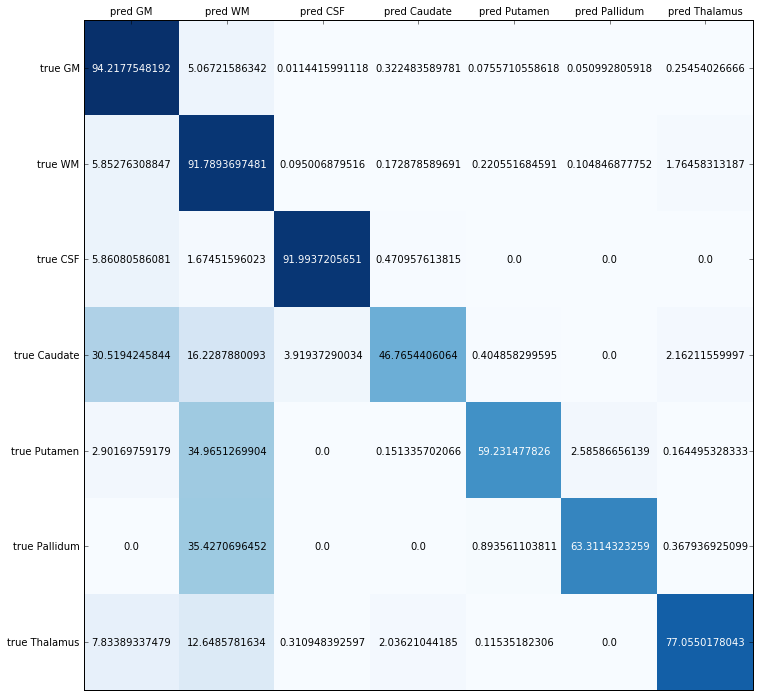

In [48]:
# Normalized confusion matrix and corresponding heat plot
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
%precision 4
np.set_printoptions(suppress=True)


x = ['pred GM', 'pred WM', 'pred CSF', 'pred Caudate', 'pred Putamen', 'pred Pallidum', 'pred Thalamus']
y = ['true GM', 'true WM', 'true CSF', 'true Caudate', 'true Putamen', 'true Pallidum', 'true Thalamus']

fig, ax = plt.subplots()
fig.set_size_inches(12,12)

norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print(norm)
heatmap = ax.pcolor(norm, cmap=plt.cm.Blues)

ax.set_yticks(np.arange(cm.shape[0])+0.5, minor=False)
ax.set_xticks(np.arange(cm.shape[1])+0.5, minor=False)

ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(x, minor=False)
ax.set_yticklabels(y, minor=False)


thresh = norm.max() / 2.
for i, j in itertools.product(range(norm.shape[0]), range(norm.shape[1])):
    plt.text(j+0.5, i+0.5, norm[i, j],
             verticalalignment="center", horizontalalignment="center",
             color="white" if norm[i, j] > thresh else "black")